>### 问题提出：
- 在前篇的线性模型中
    $$
    \widehat y = \omega x
    $$
    如果以神经网络的视角代入来看，则$x$为输入层，即input层，$\omega$为权重，$\widehat y$为输出层。在神经网络中，通常将$\omega$以及$*$计算操作的部分合并看做一个神经元（层）。而神经网络的训练过程即为更新$\omega$的过程，其更新的情况依赖于$\frac{\partial loss}{\partial \omega}$,而并非$\frac{\partial \widehat y}{\partial \omega}$.
    <image>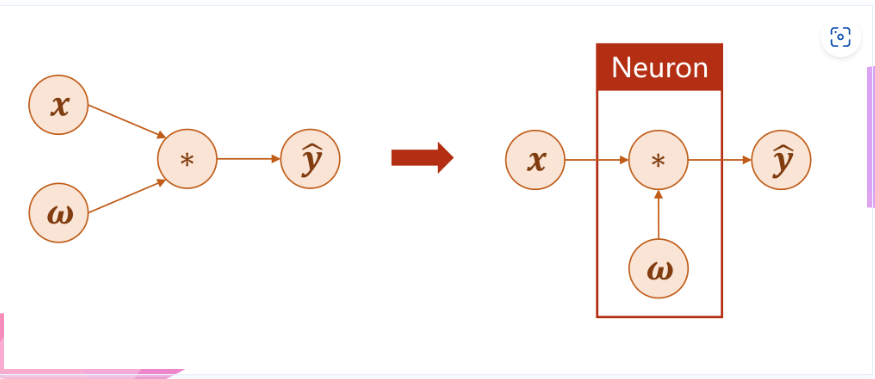</image>
- 然而，对于复杂模型而言求解过程就复杂很多
    <image>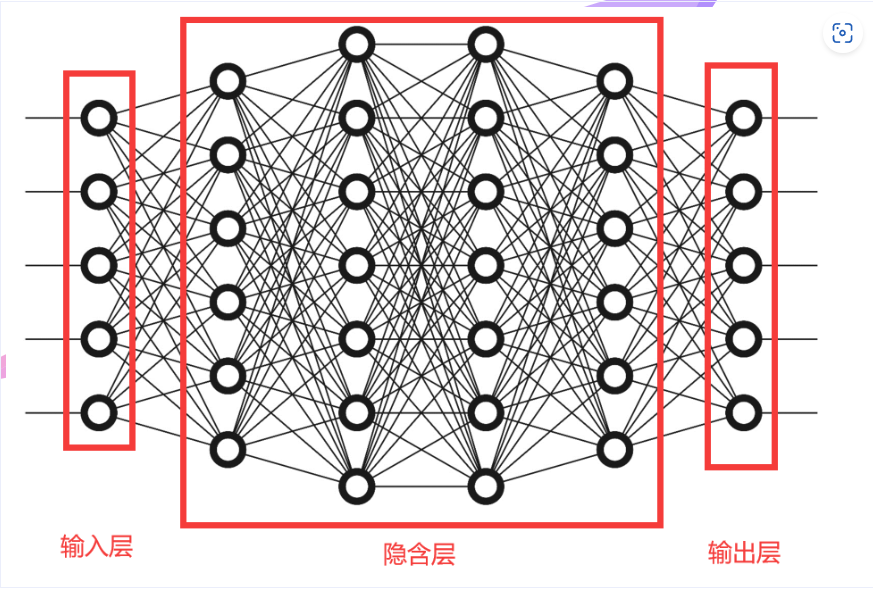</image>
    由图上可知，输入层与隐含层第一层之间就有$5*6=30$个权重，隐含层的第一层与第二层之间又有$6*7=42$个权重，以此类推，上图中共有$30+42+49+42+30=193$个权重需要计算，传统得列表达式的方式是无法完成的。


>### Computation Graph
- 在计算图中，绿色的模块为计算模块，可以在计算过程中求导。MM为矩阵乘法，ADD为加法。
    <image>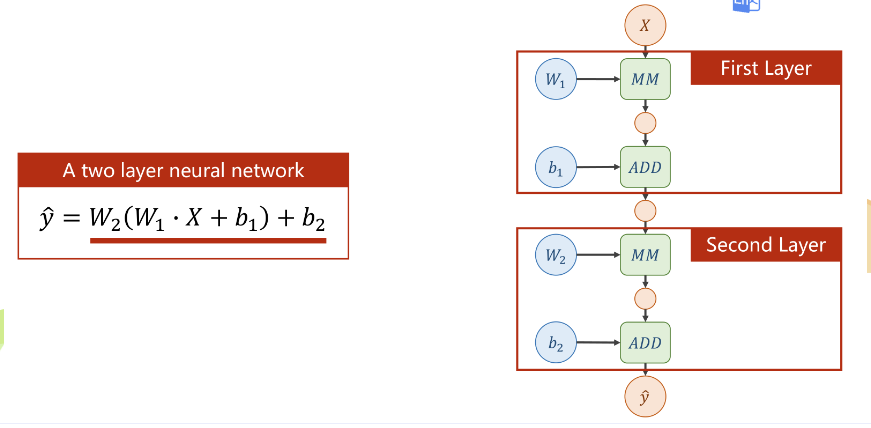</image>
    而上图左式中，可以化简得到如下公式
    $$
    \widehat y = W_2(W_1X+b_1)+b_2=W_2W_1X+(W_2b_1+b_2)=WX+b
    $$
    也就是说，在这个结构下单纯的增加层数，并不能增加神经网络的复杂程度，因为最后都可以化简为一个单一的神经网络
- 因此，在每一层神经元后加Sigmoid函数
    <image>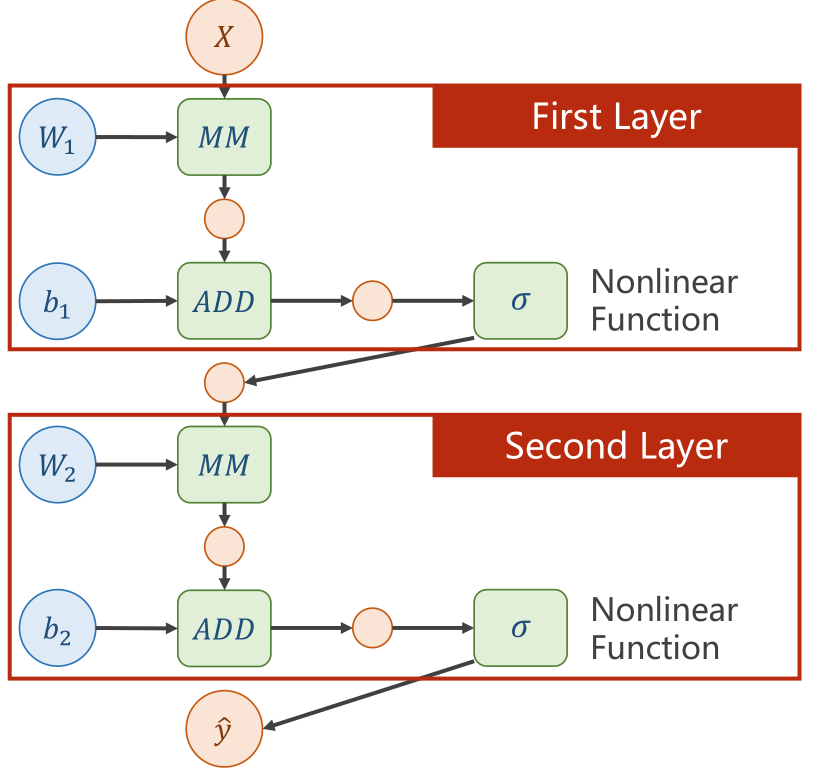</image>

>### The composition of functions and Chain Rule
- 求导的链式法则
- 目的：得到loss关于weight的梯度
1. Create Computation Graph(Forward)
    - 在某一神经元处，输入的$x$与$\omega$经过函数$f(x,\omega)$的计算,可以获得输出值$z$，并继续向前以得到损失值loss.
    在向前计算的过程中，在$f(x,\omega)$的计算模块中会计算导数$\frac{\partial z}{\partial x}$以及$\frac{\partial z}{\partial \omega}$,并将其保存下来（在pytorch中，这样的值保存在变量$x$以及$\omega$中）。
    <image>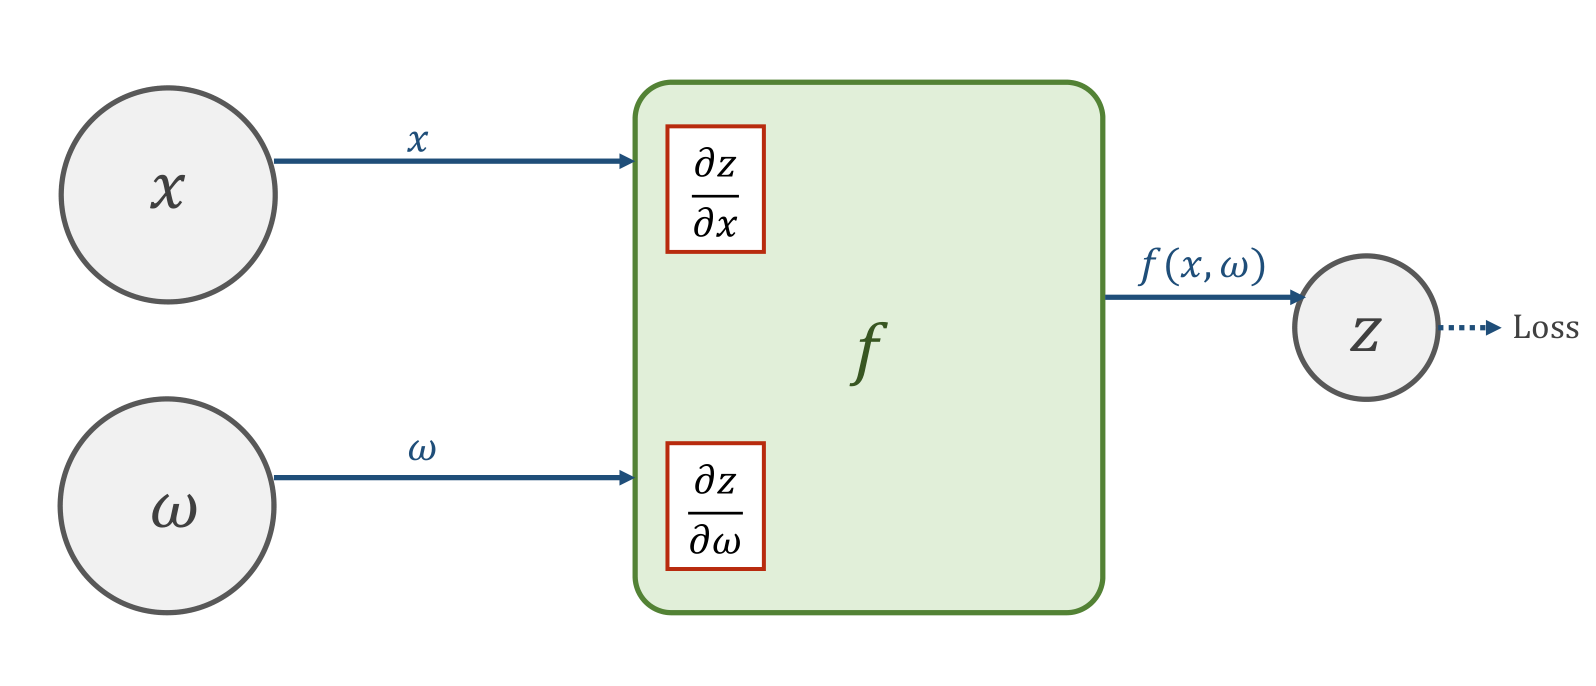</image>
2. Backward
    - 由于求导的链式法则,求得loss以后，前面的神经元会将$\frac{\partial loss}{\partial z}$的值反向传播给原先的神经元，在计算单元$f(x,\omega)$中,将得到的$\frac{\partial loss}{\partial x}$与之前存储的导数相乘，即可得到损失值对于权重以及输入层的导数，即$\frac{\partial loss}{\partial x}$,以及$\frac{\partial loss}{\partial \omega}$.基于该梯度才进行权重的调整。
    <image>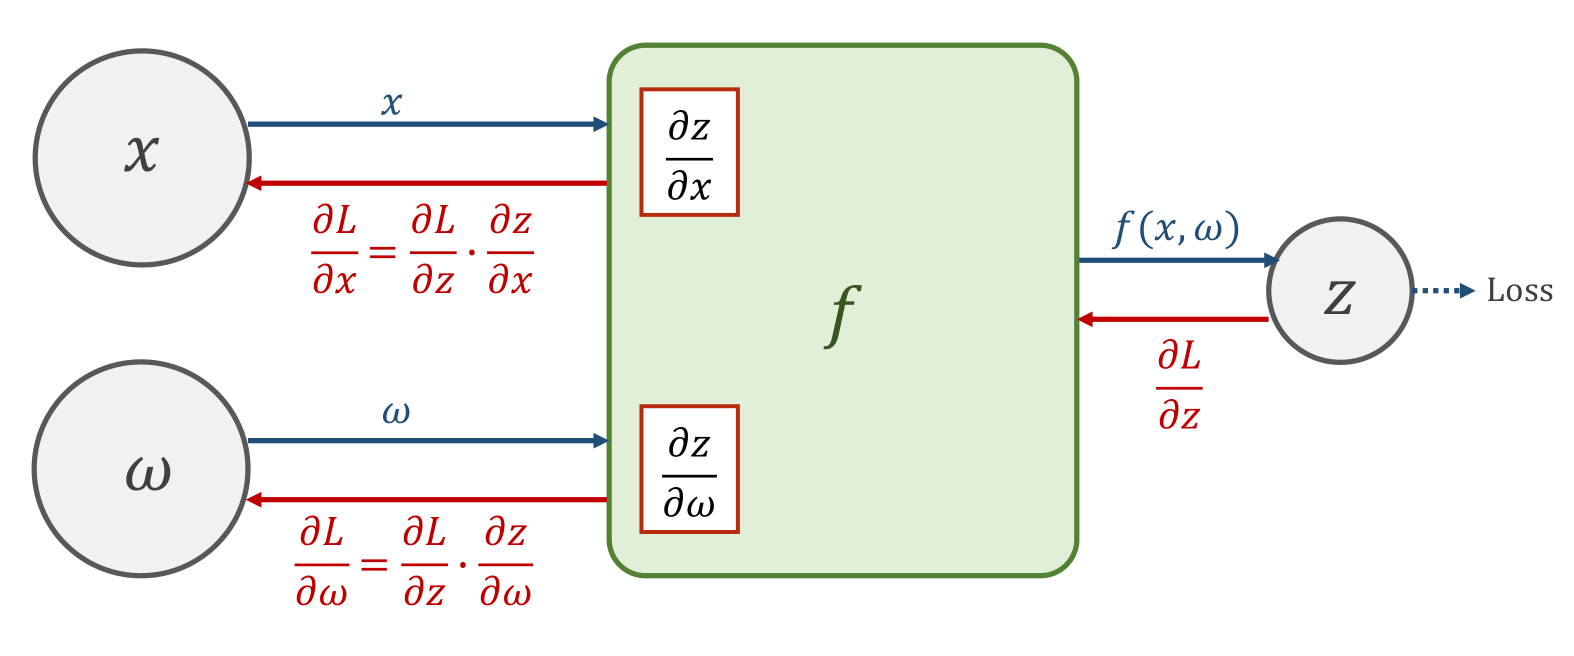</image>

>### Computation Graph of Linear Model
- Forward
    <image>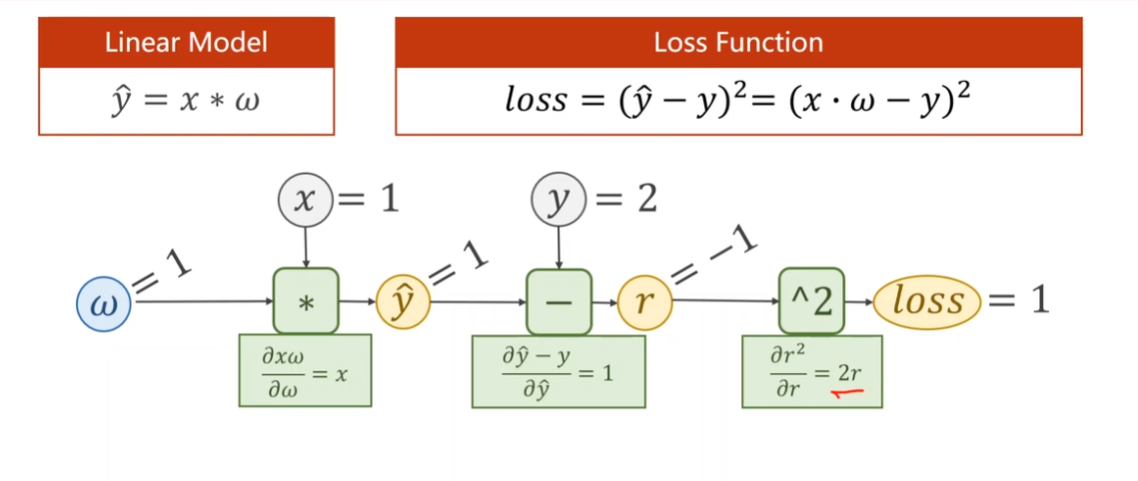</image>
- Backward
    <image>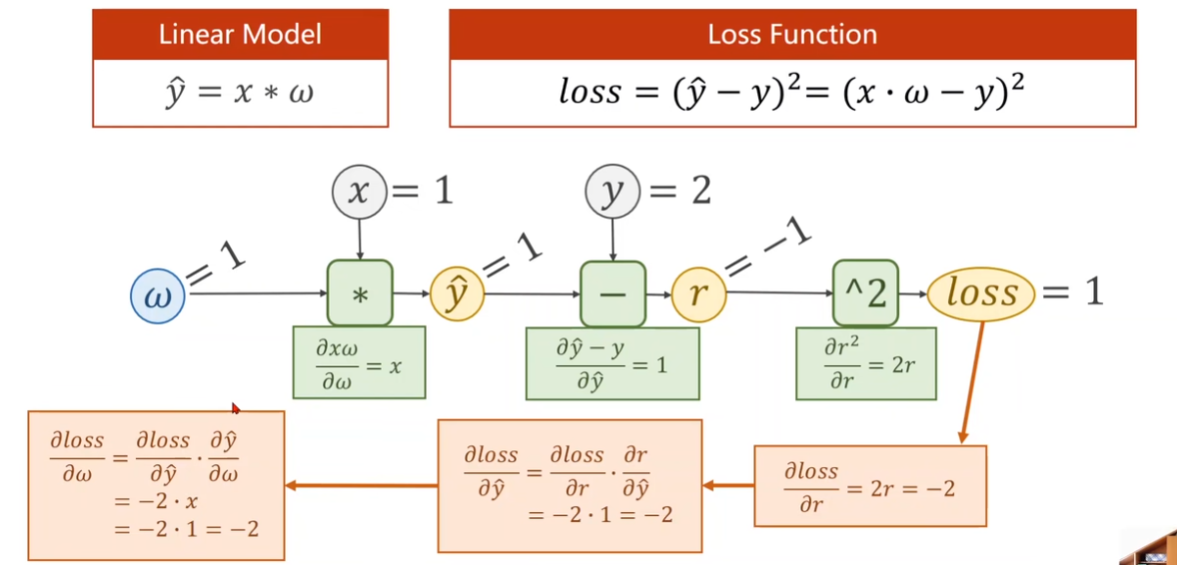</image>


>### Tensor in PyTorch
- 在Torch里面，Tensor用来保存数据的
- Tensor中重要的两个成员，data用于保存权重本身的值$\omega$,grad用于保存损失函数对权重的导数$\frac{\partial loss}{\partial \omega}$，grad本身也是个张量。对张量进行的计算操作，都是建立计算图的过程。

In [11]:
import torch

x_data = [1.0,2.0,3.0]
y_data = [2.0, 4.0, 6.0]

w = torch.Tensor([1.0])
# 设置Tensor需要计算梯度
w.requires_grad = True

def forward(x):
    # *被重载了，需要进行Tensor中的乘法
    return x * w 

def loss(x, y):
    """每调用一次loss函数,动态构建计算图"""
    y_pred = forward(x)
    return (y_pred - y) ** 2

print('predict (before training)', 4, forward(4).item())

for epoch in range(100):
    for x, y in zip(x_data,y_data):
        # 调用时即创建计算图
        l = loss(x, y)
        # 计算后返回梯度，释放计算图
        l.backward()
        print("\tgrad:",x, y, w.grad.data)
        # .data,.item()都是取值转化为标量
        w.data = w.data - 0.01 * w.grad.data
        # 清零梯度数据
        w.grad.data.zero_() 

    print("progress: ", epoch, l.item())

print('predict (after training)', 4, forward(4).item())

predict (before training) 4 4.0
	grad: 1.0 2.0 tensor([-2.])
	grad: 2.0 4.0 tensor([-7.8400])
	grad: 3.0 6.0 tensor([-16.2288])
progress:  0 7.315943717956543
	grad: 1.0 2.0 tensor([-1.4786])
	grad: 2.0 4.0 tensor([-5.7962])
	grad: 3.0 6.0 tensor([-11.9981])
progress:  1 3.9987640380859375
	grad: 1.0 2.0 tensor([-1.0932])
	grad: 2.0 4.0 tensor([-4.2852])
	grad: 3.0 6.0 tensor([-8.8704])
progress:  2 2.1856532096862793
	grad: 1.0 2.0 tensor([-0.8082])
	grad: 2.0 4.0 tensor([-3.1681])
	grad: 3.0 6.0 tensor([-6.5580])
progress:  3 1.1946394443511963
	grad: 1.0 2.0 tensor([-0.5975])
	grad: 2.0 4.0 tensor([-2.3422])
	grad: 3.0 6.0 tensor([-4.8484])
progress:  4 0.6529689431190491
	grad: 1.0 2.0 tensor([-0.4417])
	grad: 2.0 4.0 tensor([-1.7316])
	grad: 3.0 6.0 tensor([-3.5845])
progress:  5 0.35690122842788696
	grad: 1.0 2.0 tensor([-0.3266])
	grad: 2.0 4.0 tensor([-1.2802])
	grad: 3.0 6.0 tensor([-2.6500])
progress:  6 0.195076122879982
	grad: 1.0 2.0 tensor([-0.2414])
	grad: 2.0 4.0 tensor

In [14]:
import torch

x_data = [1.0,2.0,3.0]
y_data = [2.0,4.0,6.0]

w1 = torch.Tensor([1.0])
w2 = torch.Tensor([1.0])
b = torch.Tensor([1.0])
w1.requires_grad = True
w2.requires_grad = True
b.requires_grad = True

def forward1(x):
    return (w1 ** 2) * x
    
def forward2(x):
    return w2 * x

def loss(x, y):
    y_pred = forward1(x) + forward2(x) + b
    return (y_pred - y) ** 2

print('predict (before training)', 4, forward(4).item())

for epoch in range(100):
    for x, y in zip(x_data,y_data):
        l = loss(x, y)
        l.backward()
        w1.data = w1.data - 0.01 * w1.grad.data
        w2.data = w2.data - 0.01 * w2.grad.data
        b.data = b.data - 0.01 * b.grad.data

        w1.grad.data.zero_() 
        w2.grad.data.zero_() 
        b.grad.data.zero_() 

    print("progress ", epoch, l.item())

print('predict (after training)', 4, forward(4).item())

predict (before training) 4 7.999998569488525
progress  0 0.05738082900643349
progress  1 0.054019927978515625
progress  2 0.08991516381502151
progress  3 0.09653060138225555
progress  4 0.09649741649627686
progress  5 0.09512359648942947
progress  6 0.09350515902042389
progress  7 0.09186100214719772
progress  8 0.09023458510637283
progress  9 0.08863376826047897
progress  10 0.08706049621105194
progress  11 0.0855141431093216
progress  12 0.08399436622858047
progress  13 0.08249998837709427
progress  14 0.08103205263614655
progress  15 0.07958940416574478
progress  16 0.07817143946886063
progress  17 0.0767781138420105
progress  18 0.07540857791900635
progress  19 0.0740625262260437
progress  20 0.07274068892002106
progress  21 0.071440689265728
progress  22 0.0701640397310257
progress  23 0.06890890002250671
progress  24 0.06767601519823074
progress  25 0.06646408885717392
progress  26 0.06527359038591385
progress  27 0.06410374492406845
progress  28 0.06295429170131683
progress  29